In [135]:
import pandas as pd
import numpy as np
import requests
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re



# Pull data

Data source: Alphavantage

In [2]:
api_key= 'CQ5VLYHXDSWTAHB4' #premium API

Returns daily data for a stock (symbol)
outputsize: compact(last 100) or full (20 years)

In [18]:
throttle=0
output_size='full'
symbol='NKE' #Nike company
#pull data of the "symbol" stock from alphavantage.co
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={api_key}'
r = requests.get(url)
time.sleep(throttle)
data = r.json()
#convert to dataframe:
df_NKE = pd.DataFrame(data['Time Series (Daily)']).T
df_NKE.columns = ['open','high','low','close','volume']
#add stock symbol column to the dataframe:
df_NKE['symbol'] = data['Meta Data']['2. Symbol']
#format the index value as datetime format:
df_NKE.index = pd.to_datetime(df_NKE.index)
#format the data value as float type:
for col in ['open','high','low','close','volume']:
    df_NKE[col] = df_NKE[col].astype('float')
#view the data:
df_NKE


open    high      low   close     volume symbol
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE
...            ...     ...      ...     ...        ...    ...
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE

[6112 rows x 6 columns]

### Pull Economics data

Data source: Alphavantage

#### Economic data to be collected: Inflation, Federal funds rate, Treasury yield, Unemployee rate
</br>Monthly data: Inflation, Unemployee rate, Retail sales value (millions of dollar), CPI (Consumer Price Index)
</br>Daily, Weekly, Monthly Data: Federal funds rate, treasury yield

In [90]:

# Pulling data function:
def get_economics_indicator(funct,api_key,interval=None,maturity=None,throttle=0):
    if funct in ['INFLATION','UNEMPLOYMENT','RETAIL_SALES']:
        url=f'https://www.alphavantage.co/query?function={funct}&apikey={api_key}&outputsize={output_size}'
    if funct in ['FEDERAL_FUNDS_RATE','CPI']:
        url=f'https://www.alphavantage.co/query?function={funct}&interval={interval}&apikey={api_key}&outputsize={output_size}'
    if funct =='TREASURY_YIELD':
        url=f'https://www.alphavantage.co/query?function={funct}&interval={interval}&maturity={maturity}&apikey={api_key}&outputsize={output_size}'
    r = requests.get(url)
    time.sleep(throttle)
    data = r.json()
    #convert to dataframe:
    df= pd.DataFrame(data['data'])
    #reformat the date and set date as index:
    df.date = pd.to_datetime(df.date)
    df.set_index('date',inplace=True)
    # add stock name and interval columns:
    df['name'] = data['name']
    df['interval']=data['interval']
    # format value as float type:
    df.value = df.value.astype('float')
    # filling missing value due to monthly date data and reindex to daily, fill missing values forward:
    if funct in ['INFLATION','UNEMPLOYMENT','RETAIL_SALES','CPI']:
        df.value.interpolate(method='time',inplace=True)
        days = pd.date_range(start=min(df.index),end=max(df.index),freq='D')
        df =df.reindex(days,method = 'ffill')
    
    return df
# Pull Monthly data:
# INFLATION, UNEMPLOYMENT:
# get 'INFLATION':
df_monthly=df_NKE.join(get_economics_indicator('INFLATION',api_key,throttle=0),how='left')
df_monthly.rename(columns={"value": 'inflation'},inplace=True)
df_monthly.drop(['name', 'interval'], axis=1,inplace = True)
# get 'UNEMPLOYMENT'
df_monthly=df_monthly.join(get_economics_indicator('UNEMPLOYMENT',api_key,throttle=0),how='left')
df_monthly.rename(columns={"value": 'unemployment'},inplace=True)
df_monthly.drop(['name', 'interval'], axis=1,inplace = True)
# get 'RETAIL_SALES':
df_monthly=df_monthly.join(get_economics_indicator('RETAIL_SALES',api_key,throttle=0),how='left')
df_monthly.rename(columns={"value": 'retail_sales'},inplace=True)
df_monthly.drop(['name', 'interval'], axis=1,inplace = True)
# get 'CPI':
df_monthly=df_monthly.join(get_economics_indicator('CPI',api_key,interval='monthly',throttle=0),how='left')
df_monthly.rename(columns={"value": 'CPI'},inplace=True)
df_monthly.drop(['name', 'interval'], axis=1,inplace = True)
df_monthly
    

open    high      low   close     volume symbol  inflation  \
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE        NaN   
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE        NaN   
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE        NaN   
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE        NaN   
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE        NaN   
...            ...     ...      ...     ...        ...    ...        ...   
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE   3.376857   
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE   3.376857   
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE   3.376857   
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE   3.376857   
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE   3.376857   

            unemployment  retail_sales    CPI  
2024-02-15           NaN           NaN    NaN  
2024-02-14           NaN           NaN    NaN  
2024-02-13           NaN           NaN    NaN  
2024-02-12           NaN           NaN    NaN  
2024-02-09           NaN           NaN    NaN  
...                  ...           ...    ...  
1999-11-05           4.0      293013.0  168.3  
1999-11-04           4.0      293013.0  168.3  
1999-11-03           4.0      293013.0  168.3  
1999-11-02           4.0      293013.0  168.3  
1999-11-01           4.1      240857.0  168.3  

[6112 rows x 10 columns]

In [91]:
df_monthly.describe()

open         high          low        close        volume  \
count  6112.000000  6112.000000  6112.000000  6112.000000  6.112000e+03   
mean     78.946154    79.778363    78.118254    78.969536  4.305663e+06   
std      27.744502    27.916340    27.544517    27.720548  3.743613e+06   
min      26.940000    27.060000    25.810000    26.560000  1.825000e+05   
25%      56.435000    57.115000    55.830000    56.557500  1.754725e+06   
50%      76.200000    76.895000    75.485000    76.175000  3.236150e+06   
75%      95.015000    95.912500    94.155000    94.967500  5.885862e+06   
max     176.350000   179.100000   175.495000   177.510000  4.817606e+07   

         inflation  unemployment   retail_sales          CPI  
count  5579.000000   6080.000000    6080.000000  6080.000000  
mean      2.460841      5.754819  375366.366283   226.516317  
std       1.650115      1.975676  102627.164669    35.114964  
min      -0.355546      3.400000  213709.000000   168.300000  
25%       1.586032      4.300000  299238.000000   198.700000  
50%       2.270095      5.200000  351517.000000   226.889000  
75%       3.156842      6.700000  423071.000000   247.867000  
max       8.002800     14.800000  672967.000000   308.417000

In [92]:
# Get daily data:
# Get FEDERAL_FUNDS_RATE:
df_daily=df_monthly.join(get_economics_indicator('FEDERAL_FUNDS_RATE',api_key,interval='daily',throttle=0),how='left')
df_daily.rename(columns={"value": 'fed_funds_rate'},inplace=True)
df_daily.drop(['name', 'interval'], axis=1,inplace = True)
# Get TREASURY_YIELD:
# 5 year:
df_daily = df_daily.join(get_economics_indicator('FEDERAL_FUNDS_RATE',api_key,interval='daily',maturity='5year',throttle=0),how='left')
df_daily.rename(columns={"value": 'yield5y'},inplace=True)
df_daily.drop(['name', 'interval'], axis=1,inplace = True)
# 10 year
df_daily = df_daily.join(get_economics_indicator('FEDERAL_FUNDS_RATE',api_key,interval='daily',maturity='10year',throttle=0),how='left')
df_daily.rename(columns={"value": 'yield10y'},inplace=True)
df_daily.drop(['name', 'interval'], axis=1,inplace = True)
# 30 year
df_daily = df_daily.join(get_economics_indicator('FEDERAL_FUNDS_RATE',api_key,interval='daily',maturity='30year',throttle=0),how='left')
df_daily.rename(columns={"value": 'yield30y'},inplace=True)
df_daily.drop(['name', 'interval'], axis=1,inplace = True)
# 3 month
df_daily = df_daily.join(get_economics_indicator('FEDERAL_FUNDS_RATE',api_key,interval='daily',maturity='3month',throttle=0),how='left')
df_daily.rename(columns={"value": 'yield3m'},inplace=True)
df_daily.drop(['name', 'interval'], axis=1,inplace = True)

df_daily

open    high      low   close     volume symbol  inflation  \
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE        NaN   
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE        NaN   
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE        NaN   
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE        NaN   
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE        NaN   
...            ...     ...      ...     ...        ...    ...        ...   
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE   3.376857   
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE   3.376857   
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE   3.376857   
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE   3.376857   
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE   3.376857   

            unemployment  retail_sales    CPI  fed_funds_rate  yield5y  \
2024-02-15           NaN           NaN    NaN            5.33     5.33   
2024-02-14           NaN           NaN    NaN            5.33     5.33   
2024-02-13           NaN           NaN    NaN            5.33     5.33   
2024-02-12           NaN           NaN    NaN            5.33     5.33   
2024-02-09           NaN           NaN    NaN            5.33     5.33   
...                  ...           ...    ...             ...      ...   
1999-11-05           4.0      293013.0  168.3            5.14     5.14   
1999-11-04           4.0      293013.0  168.3            5.27     5.27   
1999-11-03           4.0      293013.0  168.3            5.21     5.21   
1999-11-02           4.0      293013.0  168.3            5.18     5.18   
1999-11-01           4.1      240857.0  168.3            5.38     5.38   

            yield10y  yield30y  yield3m  
2024-02-15      5.33      5.33     5.33  
2024-02-14      5.33      5.33     5.33  
2024-02-13      5.33      5.33     5.33  
2024-02-12      5.33      5.33     5.33  
2024-02-09      5.33      5.33     5.33  
...              ...       ...      ...  
1999-11-05      5.14      5.14     5.14  
1999-11-04      5.27      5.27     5.27  
1999-11-03      5.21      5.21     5.21  
1999-11-02      5.18      5.18     5.18  
1999-11-01      5.38      5.38     5.38  

[6112 rows x 15 columns]

### Pull Technical data:

Returns Technical Indicators:
<li>MACD</li>
<li>RSI</li>
<li>BBANDS </li>
<li>STOCH</li>

</br>Parameters:
<li>interval: (1min, 5min, 15min, 30min, 60min, daily, weekly, monthly)</li>
<li>series_type: (open, close,high,low)-default to close</li>
<li>time_periods: is the number of data points used to calculate each RSI value.</li>


In [93]:
# Query function:
def get_technical_data(symbol,funct,api_key,interval,time_period=None,throttle=0):
    if funct == 'MACD':
        url=f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&apikey={api_key}&outputsize={output_size}'
    if funct in ['RSI','BBANDS']:
        url=f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&time_period={time_period}&apikey={api_key}&outputsize={output_size}'
    if funct=='STOCH':
        url=f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&apikey={api_key}&outputsize={output_size}'
    r = requests.get(url)
    time.sleep(throttle)
    data = r.json()
    # convert to dataframe:
    df = pd.DataFrame(data[f'Technical Analysis: {funct}']).T
    # convert index to datetime:
    df.index = pd.to_datetime(df.index)
    #reformat the data to float:
    for col in df.columns:
        df[col] = df[col].astype('float')
    return df

    

In [94]:
# Get MACD:
df_technical = df_daily.join(get_technical_data(symbol,'MACD',api_key,interval='daily',throttle=0),how='left')
# Get RSI:
# popular value for time_period is 14-daytime (according to 'All about market indicators' - The McGraw):
df_technical = df_technical.join(get_technical_data(symbol,'RSI',api_key,interval='daily',time_period=14, throttle=0),how='left')
# Get BBANDS:
# popular value for time_period is 20-period MA (according to 'All about market indicators' - The McGraw):
df_technical = df_technical.join(get_technical_data(symbol,'BBANDS',api_key,interval='daily',time_period=20, throttle=0),how='left')
#Get STOCH:
df_technical = df_technical.join(get_technical_data(symbol,'STOCH',api_key,interval='daily', throttle=0),how='left')
df_technical

open    high      low   close     volume symbol  inflation  \
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE        NaN   
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE        NaN   
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE        NaN   
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE        NaN   
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE        NaN   
...            ...     ...      ...     ...        ...    ...        ...   
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE   3.376857   
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE   3.376857   
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE   3.376857   
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE   3.376857   
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE   3.376857   

            unemployment  retail_sales    CPI  ...  yield3m    MACD  \
2024-02-15           NaN           NaN    NaN  ...     5.33  0.0293   
2024-02-14           NaN           NaN    NaN  ...     5.33 -0.1351   
2024-02-13           NaN           NaN    NaN  ...     5.33 -0.3714   
2024-02-12           NaN           NaN    NaN  ...     5.33 -0.5321   
2024-02-09           NaN           NaN    NaN  ...     5.33 -0.9516   
...                  ...           ...    ...  ...      ...     ...   
1999-11-05           4.0      293013.0  168.3  ...     5.14     NaN   
1999-11-04           4.0      293013.0  168.3  ...     5.27     NaN   
1999-11-03           4.0      293013.0  168.3  ...     5.21     NaN   
1999-11-02           4.0      293013.0  168.3  ...     5.18     NaN   
1999-11-01           4.1      240857.0  168.3  ...     5.38     NaN   

            MACD_Signal  MACD_Hist      RSI  Real Upper Band  \
2024-02-15      -0.7664     0.7957  54.7524         107.1292   
2024-02-14      -0.9653     0.8303  55.5998         106.7110   
2024-02-13      -1.1729     0.8015  52.3470         106.1511   
2024-02-12      -1.3733     0.8411  58.9164         105.8060   
2024-02-09      -1.5835     0.6320  52.0466         105.1958   
...                 ...        ...      ...              ...   
1999-11-05          NaN        NaN      NaN              NaN   
1999-11-04          NaN        NaN      NaN              NaN   
1999-11-03          NaN        NaN      NaN              NaN   
1999-11-02          NaN        NaN      NaN              NaN   
1999-11-01          NaN        NaN      NaN              NaN   

            Real Middle Band  Real Lower Band    SlowK    SlowD  
2024-02-15          102.9745          98.8198  64.4738  73.2061  
2024-02-14          102.7190          98.7270  74.6893  81.6098  
2024-02-13          102.4435          98.7359  80.4553  85.7871  
2024-02-12          102.2795          98.7530  89.6848  85.3288  
2024-02-09          102.1735          99.1512  87.2212  74.2464  
...                      ...              ...      ...      ...  
1999-11-05               NaN              NaN      NaN      NaN  
1999-11-04               NaN              NaN      NaN      NaN  
1999-11-03               NaN              NaN      NaN      NaN  
1999-11-02               NaN              NaN      NaN      NaN  
1999-11-01               NaN              NaN      NaN      NaN  

[6112 rows x 24 columns]

In [95]:
df_technical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6112 entries, 2024-02-15 to 1999-11-01
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              6112 non-null   float64
 1   high              6112 non-null   float64
 2   low               6112 non-null   float64
 3   close             6112 non-null   float64
 4   volume            6112 non-null   float64
 5   symbol            6112 non-null   object 
 6   inflation         5579 non-null   float64
 7   unemployment      6080 non-null   float64
 8   retail_sales      6080 non-null   float64
 9   CPI               6080 non-null   float64
 10  fed_funds_rate    6112 non-null   float64
 11  yield5y           6112 non-null   float64
 12  yield10y          6112 non-null   float64
 13  yield30y          6112 non-null   float64
 14  yield3m           6112 non-null   float64
 15  MACD              6079 non-null   float64
 16  MACD_Signal       6079 n

# Clean the data

These are tasks which will be done to make the data clean:
<li>Change column names</li>
<li>Deal with missing data</li>



In [96]:
df_technical=df_technical.rename(columns={'Real Upper Band':'bbands-upper',
                                        'Real Lower Band':'bbands-lower',
                                        'Real Middle Band':'bbands-middle',
                                        'SlowK':'stoch-slowK',
                                        'SlowD':'stoch-slowD'})
df_technical

open    high      low   close     volume symbol  inflation  \
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE        NaN   
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE        NaN   
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE        NaN   
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE        NaN   
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE        NaN   
...            ...     ...      ...     ...        ...    ...        ...   
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE   3.376857   
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE   3.376857   
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE   3.376857   
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE   3.376857   
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE   3.376857   

            unemployment  retail_sales    CPI  ...  yield3m    MACD  \
2024-02-15           NaN           NaN    NaN  ...     5.33  0.0293   
2024-02-14           NaN           NaN    NaN  ...     5.33 -0.1351   
2024-02-13           NaN           NaN    NaN  ...     5.33 -0.3714   
2024-02-12           NaN           NaN    NaN  ...     5.33 -0.5321   
2024-02-09           NaN           NaN    NaN  ...     5.33 -0.9516   
...                  ...           ...    ...  ...      ...     ...   
1999-11-05           4.0      293013.0  168.3  ...     5.14     NaN   
1999-11-04           4.0      293013.0  168.3  ...     5.27     NaN   
1999-11-03           4.0      293013.0  168.3  ...     5.21     NaN   
1999-11-02           4.0      293013.0  168.3  ...     5.18     NaN   
1999-11-01           4.1      240857.0  168.3  ...     5.38     NaN   

            MACD_Signal  MACD_Hist      RSI  bbands-upper  bbands-middle  \
2024-02-15      -0.7664     0.7957  54.7524      107.1292       102.9745   
2024-02-14      -0.9653     0.8303  55.5998      106.7110       102.7190   
2024-02-13      -1.1729     0.8015  52.3470      106.1511       102.4435   
2024-02-12      -1.3733     0.8411  58.9164      105.8060       102.2795   
2024-02-09      -1.5835     0.6320  52.0466      105.1958       102.1735   
...                 ...        ...      ...           ...            ...   
1999-11-05          NaN        NaN      NaN           NaN            NaN   
1999-11-04          NaN        NaN      NaN           NaN            NaN   
1999-11-03          NaN        NaN      NaN           NaN            NaN   
1999-11-02          NaN        NaN      NaN           NaN            NaN   
1999-11-01          NaN        NaN      NaN           NaN            NaN   

            bbands-lower  stoch-slowK  stoch-slowD  
2024-02-15       98.8198      64.4738      73.2061  
2024-02-14       98.7270      74.6893      81.6098  
2024-02-13       98.7359      80.4553      85.7871  
2024-02-12       98.7530      89.6848      85.3288  
2024-02-09       99.1512      87.2212      74.2464  
...                  ...          ...          ...  
1999-11-05           NaN          NaN          NaN  
1999-11-04           NaN          NaN          NaN  
1999-11-03           NaN          NaN          NaN  
1999-11-02           NaN          NaN          NaN  
1999-11-01           NaN          NaN          NaN  

[6112 rows x 24 columns]

In [97]:
# Fill in any missing data:
df_technical.fillna(method='bfill',inplace=True,axis = 0)
df_technical.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6112 entries, 2024-02-15 to 1999-11-01
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            6112 non-null   float64
 1   high            6112 non-null   float64
 2   low             6112 non-null   float64
 3   close           6112 non-null   float64
 4   volume          6112 non-null   float64
 5   symbol          6112 non-null   object 
 6   inflation       6112 non-null   float64
 7   unemployment    6112 non-null   float64
 8   retail_sales    6112 non-null   float64
 9   CPI             6112 non-null   float64
 10  fed_funds_rate  6112 non-null   float64
 11  yield5y         6112 non-null   float64
 12  yield10y        6112 non-null   float64
 13  yield30y        6112 non-null   float64
 14  yield3m         6112 non-null   float64
 15  MACD            6079 non-null   float64
 16  MACD_Signal     6079 non-null   float64
 17  MACD_Hist      

In [98]:
df_technical

open    high      low   close     volume symbol  inflation  \
2024-02-15  107.02  107.34  105.830  106.05  7019618.0    NKE   8.002800   
2024-02-14  104.82  106.42  104.460  106.33  5743277.0    NKE   8.002800   
2024-02-13  104.99  105.80  104.245  105.00  6180509.0    NKE   8.002800   
2024-02-12  104.74  107.43  104.645  107.18  7501946.0    NKE   8.002800   
2024-02-09  103.80  104.94  103.330  104.50  5449022.0    NKE   8.002800   
...            ...     ...      ...     ...        ...    ...        ...   
1999-11-05   50.19   50.81   47.000   47.94  1653700.0    NKE   3.376857   
1999-11-04   50.06   51.25   49.880   50.38  1494300.0    NKE   3.376857   
1999-11-03   51.50   51.56   47.750   50.19  3235000.0    NKE   3.376857   
1999-11-02   55.50   55.94   52.500   52.50  1542600.0    NKE   3.376857   
1999-11-01   55.75   56.38   55.250   56.31   896200.0    NKE   3.376857   

            unemployment  retail_sales      CPI  ...  yield3m    MACD  \
2024-02-15           3.7      554784.0  308.417  ...     5.33  0.0293   
2024-02-14           3.7      554784.0  308.417  ...     5.33 -0.1351   
2024-02-13           3.7      554784.0  308.417  ...     5.33 -0.3714   
2024-02-12           3.7      554784.0  308.417  ...     5.33 -0.5321   
2024-02-09           3.7      554784.0  308.417  ...     5.33 -0.9516   
...                  ...           ...      ...  ...      ...     ...   
1999-11-05           4.0      293013.0  168.300  ...     5.14     NaN   
1999-11-04           4.0      293013.0  168.300  ...     5.27     NaN   
1999-11-03           4.0      293013.0  168.300  ...     5.21     NaN   
1999-11-02           4.0      293013.0  168.300  ...     5.18     NaN   
1999-11-01           4.1      240857.0  168.300  ...     5.38     NaN   

            MACD_Signal  MACD_Hist      RSI  bbands-upper  bbands-middle  \
2024-02-15      -0.7664     0.7957  54.7524      107.1292       102.9745   
2024-02-14      -0.9653     0.8303  55.5998      106.7110       102.7190   
2024-02-13      -1.1729     0.8015  52.3470      106.1511       102.4435   
2024-02-12      -1.3733     0.8411  58.9164      105.8060       102.2795   
2024-02-09      -1.5835     0.6320  52.0466      105.1958       102.1735   
...                 ...        ...      ...           ...            ...   
1999-11-05          NaN        NaN      NaN           NaN            NaN   
1999-11-04          NaN        NaN      NaN           NaN            NaN   
1999-11-03          NaN        NaN      NaN           NaN            NaN   
1999-11-02          NaN        NaN      NaN           NaN            NaN   
1999-11-01          NaN        NaN      NaN           NaN            NaN   

            bbands-lower  stoch-slowK  stoch-slowD  
2024-02-15       98.8198      64.4738      73.2061  
2024-02-14       98.7270      74.6893      81.6098  
2024-02-13       98.7359      80.4553      85.7871  
2024-02-12       98.7530      89.6848      85.3288  
2024-02-09       99.1512      87.2212      74.2464  
...                  ...          ...          ...  
1999-11-05           NaN          NaN          NaN  
1999-11-04           NaN          NaN          NaN  
1999-11-03           NaN          NaN          NaN  
1999-11-02           NaN          NaN          NaN  
1999-11-01           NaN          NaN          NaN  

[6112 rows x 24 columns]

<Axes: >

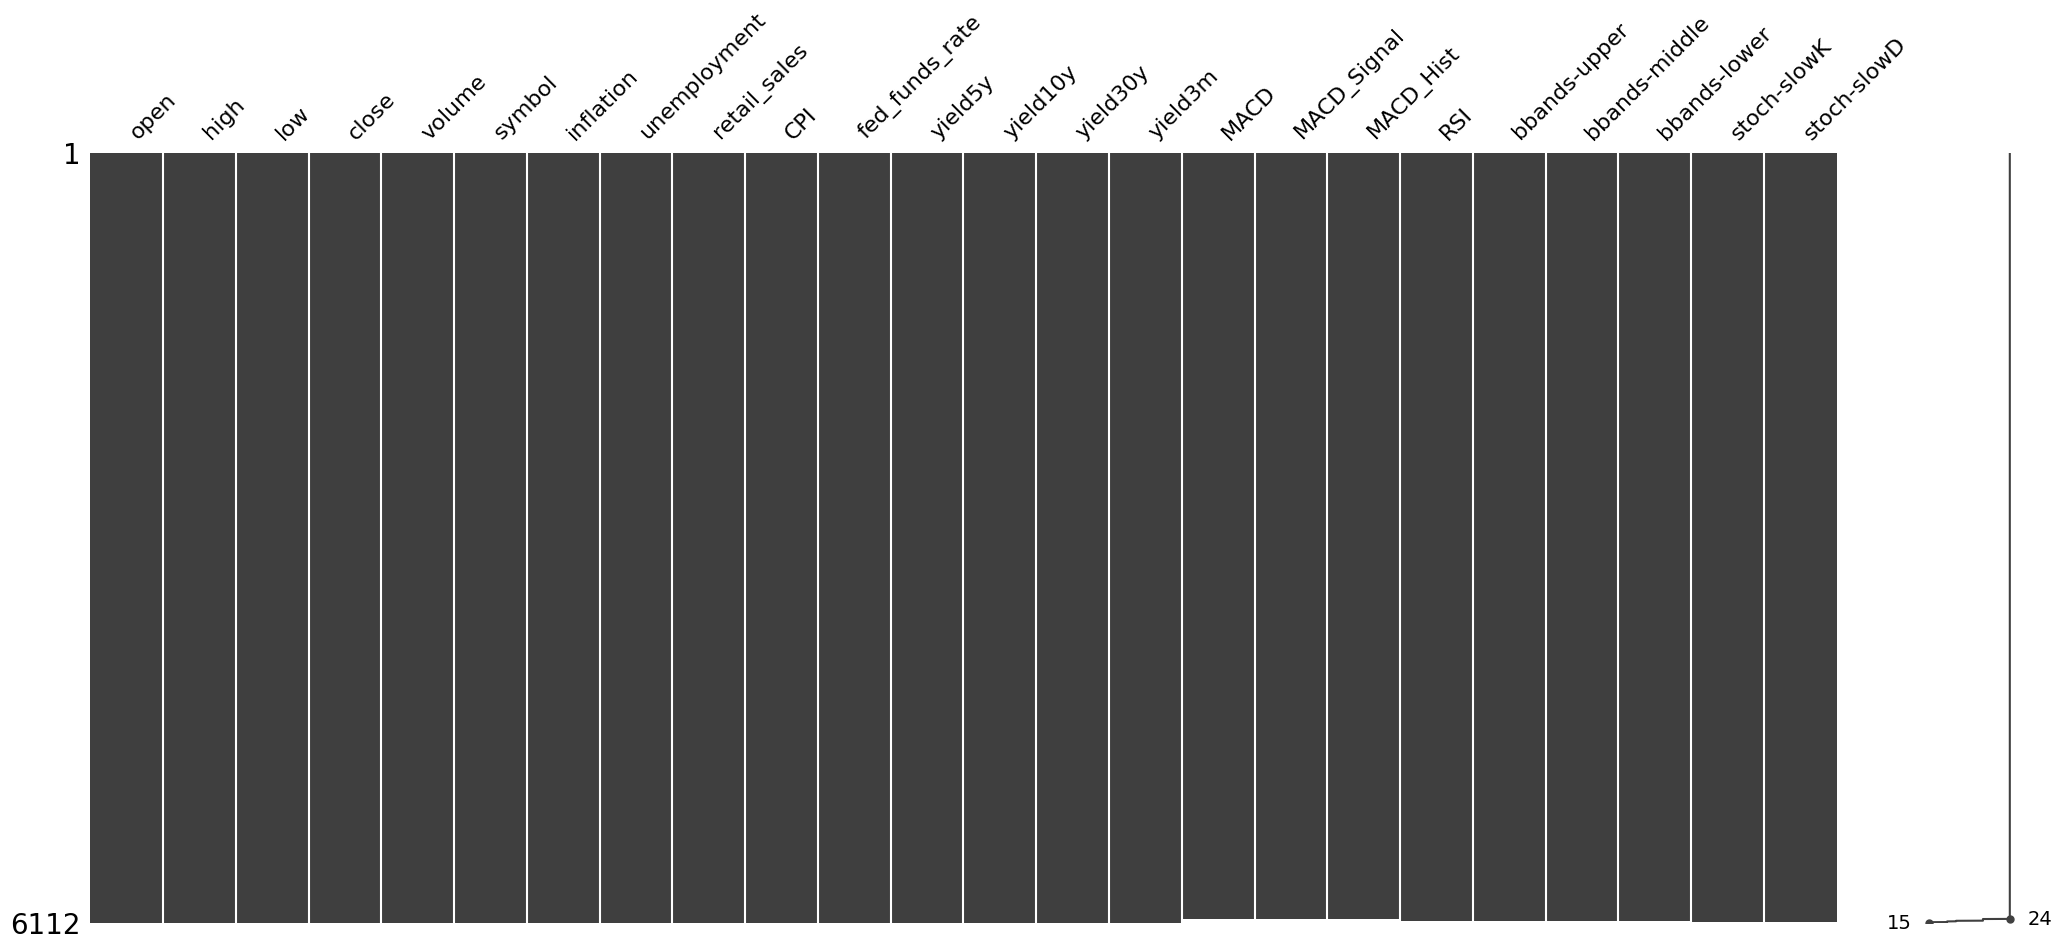

In [99]:
import missingno as msno
msno.matrix(df_technical)

In [100]:
# The missing values lies at the bottom of the dataset and the amount is just a little, so I will drop them
df_technical.dropna(axis=0,how='any',inplace=True)
df_technical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6079 entries, 2024-02-15 to 1999-12-17
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            6079 non-null   float64
 1   high            6079 non-null   float64
 2   low             6079 non-null   float64
 3   close           6079 non-null   float64
 4   volume          6079 non-null   float64
 5   symbol          6079 non-null   object 
 6   inflation       6079 non-null   float64
 7   unemployment    6079 non-null   float64
 8   retail_sales    6079 non-null   float64
 9   CPI             6079 non-null   float64
 10  fed_funds_rate  6079 non-null   float64
 11  yield5y         6079 non-null   float64
 12  yield10y        6079 non-null   float64
 13  yield30y        6079 non-null   float64
 14  yield3m         6079 non-null   float64
 15  MACD            6079 non-null   float64
 16  MACD_Signal     6079 non-null   float64
 17  MACD_Hist      

In [110]:
df_NKE_consolidated = df_technical.copy(deep=True)

# EDA

### Plot stock and economics data

### Time-series line

In [132]:
# Make subplots
fig = make_subplots(rows=7, cols=1, 
                    shared_xaxes=True, 
                    subplot_titles=('Opening Price','Closing Price','Volume','Inflation','Unemployment','Retail Sales Value','CPI'),
                    vertical_spacing=0.07)
# opening price
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated.open,name = "Open Price",line_color = '#008080',fill='tozeroy'),row=1,col=1)
# closing price
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated.close,name = "Close Price",line_color = '#a8b8d0',fill='tozeroy'),row=2,col=1)
# volume
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated.volume,name = "Volume",fill='tozeroy',fillcolor='green',mode='none'),row=3,col=1)
# Expected Inflation    
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index, y=df_NKE_consolidated.inflation,name='Inflation',line_color='gold'),row=4,col=1)
# Unemployment    
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index, y=df_NKE_consolidated.unemployment,name='Unemployment',line_color='orange'),row=5,col=1)
# Retail Sales   
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index, y=df_NKE_consolidated.retail_sales,name='Retail Sales',line_color='maroon'),row=6,col=1)
# CPI   
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index, y=df_NKE_consolidated.CPI,name='CPI(Consumer Price Index)',line_color='green'),row=7,col=1)
fig.update_layout(template='plotly_white',
                title = f"Price, Volume and Economic Indicators: {symbol}",
                width = 800,
                height = 1000)
fig.show()

In [124]:
# Distribution of closing price
fig = make_subplots(rows=1,cols=2)
fig.add_trace(go.Histogram(x=df_NKE_consolidated.close,name='histogram'),row=1,col=1)
fig.add_trace(go.Box(y=df_NKE_consolidated.close,name='boxplot'),row=1,col=2)
fig.update_layout(height=500,width=500,title_text=f'Distribution: Closing price of {symbol}')
fig.show()

In [142]:
# Federal funds rate, treasury yield in recent 3 years:
def plot_fed_rate_yield(df,year=None):
    if year is not None:
        df = df[df.index.year >= year]
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.fed_funds_rate,name='Fed Funds Rate',line_color='red'),row=1,col=1)
    colors = ['#0E340F','#29541F','#5E9C53','#A3E090','#537455','#3B463E']
    rate_cols = [c for c in df.columns if 'yield' in c]
    for i,rate in enumerate(rate_cols):
        name = str(rate)# Extract the name of the yield
        fig.add_trace(go.Scatter(x=df.index, y=df[rate],name=name,line_color = colors[i]),row=1,col=1)
    fig.update_layout(template = 'plotly_white',width= 500,height=500,title ='Federal Fund Rate & Yields')
    fig.show()
plot_fed_rate_yield(df_NKE_consolidated)

### Distribution

In [131]:
# Make subplots about Distribution:
fig = make_subplots(rows=3, cols=2,vertical_spacing=0.07)

# closing price
fig.add_trace(go.Box(y=df_NKE_consolidated.close,name = "Close Price"),row=1,col=1)
# volume
fig.add_trace(go.Box(y=df_NKE_consolidated.volume,name = "Volume"),row=1,col=2)
# Expected Inflation    
fig.add_trace(go.Box(y=df_NKE_consolidated.inflation,name='Inflation'),row=2,col=1)
# Unemployment    
fig.add_trace(go.Box(y=df_NKE_consolidated.unemployment,name='Unemployment'),row=2,col=2)
# Retail Sales   
fig.add_trace(go.Box(y=df_NKE_consolidated.retail_sales,name='Retail Sales'),row=3,col=1)
# CPI   
fig.add_trace(go.Box(y=df_NKE_consolidated.CPI,name='CPI(Consumer Price Index)'),row=3,col=2)
fig.update_layout(template='plotly_white',
                title = f"Distribution of Price, Volume and Economic Indicators: {symbol}",
                width = 800,
                height = 800)
fig.show()

In [165]:
# Technical indicators EDA
fig = make_subplots(rows=2, cols=2, 
                    shared_xaxes=True, 
                    subplot_titles=('MACD','RSI','Boolinger Bands','Stochastic'),
                    vertical_spacing=0.07)

# MACD:
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['MACD'],name='MACD',line_color='#e6daa6'),row=1,col=1)
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['MACD_Signal'],name='MACD Signal',line_color='#FFA500'),row=1,col=1)
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index, y=df_NKE_consolidated['MACD_Hist'], name='MACD Hist', marker_color='#E06D1F', marker_line_color='#E06D1F'),row=1,col=1)
# RSI:
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['RSI'],name='RSI',line_color='#F00F3C'),row=1,col=2)
# Boolinger Bands:
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['bbands-upper'],name='Bollinger-Upper',line_color="#ADD8E6"),row=2,col=1)
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['bbands-lower'],name='Bollinger-Lower',line_color='#ADD8E6',fill='tonexty'),row=2,col=1)
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated.close,name='Closing Price',line_color='#a8b8d0'),row=2,col=1)
# Stochastic:
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['stoch-slowK'],name='Stoch-slowK',line_color='#F0E68C'),row=2,col=2)
fig.add_trace(go.Scatter(x=df_NKE_consolidated.index,y=df_NKE_consolidated['stoch-slowD'],name='Stoch-slowD',line_color='#AAA662',fill='tonexty'),row=2,col=2)

fig.update_layout(template = 'plotly_white',width= 1000,height=800,title ='Technical Indicators')
fig.show()

In [152]:
df_NKE_consolidated.columns

Index(['open', 'high', 'low', 'close', 'volume', 'symbol', 'inflation',
       'unemployment', 'retail_sales', 'CPI', 'fed_funds_rate', 'yield5y',
       'yield10y', 'yield30y', 'yield3m', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'RSI', 'bbands-upper', 'bbands-middle', 'bbands-lower', 'stoch-slowK',
       'stoch-slowD'],
      dtype='object')

### Correlations

In [180]:
cm=df_NKE_consolidated.drop(columns=['open','high','low']).corr()
# plot a heatmap of correlations
fig = go.Figure()
fig.add_trace(go.Heatmap(
    z = cm,
    x = cm.columns.values,
    y = cm.columns.values,
    # colorscale = 'Bluyl'
     colorscale = 'YlOrRd'
    )
  )
fig.update_layout(
    title_text="Feature Correlations", 
    title_x=0.5, 
    width=800, 
    height=800,
    yaxis_autorange='reversed',
    template = 'plotly_white'
  )

fig.show()

/var/folders/r6/21sj3lgj1xzb_kvnzq69b41h0000gn/T/ipykernel_69599/1890068167.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# Feature Engineering

In [183]:
# get the target as the closing price:
y = df_NKE_consolidated.close
# feature list: exclude price and stock name:
feature_cols = [c for c in df_NKE_consolidated.columns if c not in ['open', 'high', 'low', 'close','symbol']]
X=df_NKE_consolidated[feature_cols]

In [185]:
X.shape

(6079, 19)

## Feature Selection

<b>Forward Feature Selection</b> method

In [184]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [186]:
lr = LinearRegression()
ffs = SequentialFeatureSelector(lr, k_features=10, forward=True, verbose=2,scoring='neg_mean_squared_error')
ffs=ffs.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished

[2024-02-23 21:21:50] Features: 1/10 -- score: -517.8793220118276[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2024-02-23 21:21:50] Features: 2/10 -- score: -453.0030588453111[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished

[2024-02-23 21:21:50] Features: 3/10 -- score: -449.6479469975212[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [221]:
ffs_features = list(ffs.k_feature_names_)
ffs_list = ['open', 'high', 'low', 'close','symbol']
ffs_list.extend(ffs_features)
print(ffs_list)

['open', 'high', 'low', 'close', 'symbol', 'volume', 'inflation', 'unemployment', 'retail_sales', 'CPI', 'MACD', 'MACD_Signal', 'RSI', 'stoch-slowK', 'stoch-slowD']


In [222]:
# dataframe after FFS selection:
df_NIKE_ffs = df_NKE_consolidated[ffs_list]
df_NIKE_ffs

open    high      low   close symbol     volume  inflation  \
2024-02-15  107.02  107.34  105.830  106.05    NKE  7019618.0   8.002800   
2024-02-14  104.82  106.42  104.460  106.33    NKE  5743277.0   8.002800   
2024-02-13  104.99  105.80  104.245  105.00    NKE  6180509.0   8.002800   
2024-02-12  104.74  107.43  104.645  107.18    NKE  7501946.0   8.002800   
2024-02-09  103.80  104.94  103.330  104.50    NKE  5449022.0   8.002800   
...            ...     ...      ...     ...    ...        ...        ...   
1999-12-23   49.69   51.94   49.560   51.88    NKE   741800.0   3.376857   
1999-12-22   49.88   50.13   49.000   49.50    NKE   632500.0   3.376857   
1999-12-21   51.00   51.00   48.250   49.13    NKE  1204900.0   3.376857   
1999-12-20   52.50   53.13   50.250   51.19    NKE  1452000.0   3.376857   
1999-12-17   49.75   55.88   49.310   52.44    NKE  5717100.0   3.376857   

            unemployment  retail_sales      CPI    MACD  MACD_Signal      RSI  \
2024-02-15           3.7      554784.0  308.417  0.0293      -0.7664  54.7524   
2024-02-14           3.7      554784.0  308.417 -0.1351      -0.9653  55.5998   
2024-02-13           3.7      554784.0  308.417 -0.3714      -1.1729  52.3470   
2024-02-12           3.7      554784.0  308.417 -0.5321      -1.3733  58.9164   
2024-02-09           3.7      554784.0  308.417 -0.9516      -1.5835  52.0466   
...                  ...           ...      ...     ...          ...      ...   
1999-12-23           4.0      213709.0  168.800  0.0592      -0.0219  57.0933   
1999-12-22           4.0      213709.0  168.800  0.0275      -0.0421  52.4784   
1999-12-21           4.0      213709.0  168.800  0.0091      -0.0596  51.7289   
1999-12-20           4.0      213709.0  168.800 -0.0109      -0.0767  56.3212   
1999-12-17           4.0      213709.0  168.800 -0.0559      -0.0932  59.2868   

            stoch-slowK  stoch-slowD  
2024-02-15      64.4738      73.2061  
2024-02-14      74.6893      81.6098  
2024-02-13      80.4553      85.7871  
2024-02-12      89.6848      85.3288  
2024-02-09      87.2212      74.2464  
...                 ...          ...  
1999-12-23      52.8862      60.7250  
1999-12-22      60.6955      70.2973  
1999-12-21      68.5932      72.9488  
1999-12-20      81.6033      64.8623  
1999-12-17      68.6498      44.0230  

[6079 rows x 15 columns]

<b> Recursive Feature Elimination (RFE) </b> method

In [190]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [191]:
rf = RandomForestRegressor(n_estimators=300,random_state=45)
rf.fit(X,y)
rfe = RFE(rf,n_features_to_select=10)
fit=rfe.fit(X,y)

In [194]:
fig = make_subplots(rows=1, cols=2,
                      subplot_titles = ('Feature Importance','Feature Ranks'),
                      shared_yaxes=True
  )
  # create the plot of feature importance
fig.add_trace(go.Bar(
              name = 'Importance',
              x=rf.feature_importances_,
              y=feature_cols,
              orientation='h',
              marker=dict(color='orange'),
              opacity = 0.5
    ),row=1,col=1
  )

  # feature rank
fig.add_trace(go.Bar(
      name = 'Rank',
      x = fit.ranking_,
      y= feature_cols,
      orientation = 'h',
      marker=dict(color='orange'),
      opacity = 0.5
    ),row=1,col=2
  )

fig.update_layout(
      title = 'Feature Importance',
      template='plotly_white',
                    width=700,
                    height=800,
                    yaxis={'categoryorder':'total descending'})

fig.show()

In [200]:
rfe_selected =[]
for i in range(len(fit.support_)):
    if fit.support_[i]:
        rfe_selected.append(feature_cols[i])
print("Top Ranked Features",rfe_selected)

Top Ranked Features ['inflation', 'unemployment', 'CPI', 'fed_funds_rate', 'yield10y', 'yield3m', 'MACD', 'bbands-upper', 'bbands-middle', 'bbands-lower']


In [223]:
# dataframe after RFE selection:
rfe_list = ['open', 'high', 'low', 'close','symbol']
rfe_list.extend(rfe_selected)
df_NIKE_rfe = df_NKE_consolidated[rfe_list]
df_NIKE_rfe

open    high      low   close symbol  inflation  unemployment  \
2024-02-15  107.02  107.34  105.830  106.05    NKE   8.002800           3.7   
2024-02-14  104.82  106.42  104.460  106.33    NKE   8.002800           3.7   
2024-02-13  104.99  105.80  104.245  105.00    NKE   8.002800           3.7   
2024-02-12  104.74  107.43  104.645  107.18    NKE   8.002800           3.7   
2024-02-09  103.80  104.94  103.330  104.50    NKE   8.002800           3.7   
...            ...     ...      ...     ...    ...        ...           ...   
1999-12-23   49.69   51.94   49.560   51.88    NKE   3.376857           4.0   
1999-12-22   49.88   50.13   49.000   49.50    NKE   3.376857           4.0   
1999-12-21   51.00   51.00   48.250   49.13    NKE   3.376857           4.0   
1999-12-20   52.50   53.13   50.250   51.19    NKE   3.376857           4.0   
1999-12-17   49.75   55.88   49.310   52.44    NKE   3.376857           4.0   

                CPI  fed_funds_rate  yield10y  yield3m    MACD  bbands-upper  \
2024-02-15  308.417            5.33      5.33     5.33  0.0293      107.1292   
2024-02-14  308.417            5.33      5.33     5.33 -0.1351      106.7110   
2024-02-13  308.417            5.33      5.33     5.33 -0.3714      106.1511   
2024-02-12  308.417            5.33      5.33     5.33 -0.5321      105.8060   
2024-02-09  308.417            5.33      5.33     5.33 -0.9516      105.1958   
...             ...             ...       ...      ...     ...           ...   
1999-12-23  168.800            5.40      5.40     5.40  0.0592        4.8941   
1999-12-22  168.800            5.45      5.45     5.45  0.0275        4.8212   
1999-12-21  168.800            5.52      5.52     5.52  0.0091        4.7943   
1999-12-20  168.800            5.54      5.54     5.54 -0.0109        4.7847   
1999-12-17  168.800            5.40      5.40     5.40 -0.0559        4.7451   

            bbands-middle  bbands-lower  
2024-02-15       102.9745       98.8198  
2024-02-14       102.7190       98.7270  
2024-02-13       102.4435       98.7359  
2024-02-12       102.2795       98.7530  
2024-02-09       102.1735       99.1512  
...                   ...           ...  
1999-12-23         4.3169        3.7396  
1999-12-22         4.2916        3.7620  
1999-12-21         4.2812        3.7680  
1999-12-20         4.2779        3.7711  
1999-12-17         4.2683        3.7916  

[6079 rows x 15 columns]

## Create Lagged features
<br>reference: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

In [241]:
def create_lag_features(df,features_to_lag,lag_days):
    # create a copy of dataframe:
    df_copy = df.copy()
    # dictionary to store optimal lag period for each feature
    d = {}
    # loop each feature, each lag:
    for feature in features_to_lag:
        max_corr = 0
        max_lag = 0
        for lag in lag_days:
            if feature != 'close':
                shift = f"_shift_{str(lag)}" #name the shifted column
                tshift = df_copy[feature].shift(lag) #lag the feature column by using shift()
                df_copy=df_copy.join(tshift,how='left',rsuffix=shift) #add the shifted column to df
                # calculate the correlation between lagged feature with the closing price:
                corr = df_copy[['close',feature+shift]].corr()[feature+shift]['close']

                #update the max abs corr and associated lag:
                if abs(corr)>max_corr:
                    max_corr=corr
                    max_lag=lag
        if max_lag<0:
            d[feature]=max_lag
    return d

# Convert the shifted features to lagged indicators:
def shift_features(df,features_to_lag):
    df_copy=df.copy()
    for feature,shift in features_to_lag.items():
        df_shift=pd.DataFrame(df_copy[feature].shift(periods=shift))
        df_copy=df_copy.join(df_shift,how='left',rsuffix='_shift')
    # remove nan value:
    df_copy.dropna(how='any',inplace=True)
    return df_copy

<b> Try with FFS feature selection method:</b>

In [243]:
# Create lag feature for FFS dataframe:
ffs_features_to_lag = [f for f in df_NIKE_ffs.columns if f not in ['open','high','low','symbol','MACD','MACD_Signal','MACD_Hist','RSI','bbands-uper','bbands-middle','bbands-lower','stoch-slowK','stoch-slowD']]
lag_range = list(range(0,-70,-10)) #lag from 0 to 60 days prior
# Find the duration of lag for features:
df_NIKE_ffs_lag_day= create_lag_features(df_NIKE_ffs,ffs_features_to_lag,lag_range)
print(df_NIKE_ffs_lag_day)

{'volume': -50, 'unemployment': -60, 'retail_sales': -10}


In [244]:
# create new dataframe with lagged features:
lag_NIKE_ffs = shift_features(df_NIKE_ffs,df_NIKE_ffs_lag_day)
lag_NIKE_ffs

open    high      low   close symbol     volume  inflation  \
2024-02-15  107.02  107.34  105.830  106.05    NKE  7019618.0   8.002800   
2024-02-14  104.82  106.42  104.460  106.33    NKE  5743277.0   8.002800   
2024-02-13  104.99  105.80  104.245  105.00    NKE  6180509.0   8.002800   
2024-02-12  104.74  107.43  104.645  107.18    NKE  7501946.0   8.002800   
2024-02-09  103.80  104.94  103.330  104.50    NKE  5449022.0   8.002800   
...            ...     ...      ...     ...    ...        ...        ...   
2000-03-21   33.13   33.44   32.250   33.13    NKE  1726200.0   2.826171   
2000-03-20   32.31   33.38   32.310   33.00    NKE  1798300.0   2.826171   
2000-03-17   34.63   36.13   32.130   34.00    NKE  3752700.0   2.826171   
2000-03-16   32.94   38.00   31.380   35.75    NKE  2178400.0   2.826171   
2000-03-15   28.63   33.50   28.560   33.00    NKE  3239100.0   2.826171   

            unemployment  retail_sales      CPI    MACD  MACD_Signal      RSI  \
2024-02-15           3.7      554784.0  308.417  0.0293      -0.7664  54.7524   
2024-02-14           3.7      554784.0  308.417 -0.1351      -0.9653  55.5998   
2024-02-13           3.7      554784.0  308.417 -0.3714      -1.1729  52.3470   
2024-02-12           3.7      554784.0  308.417 -0.5321      -1.3733  58.9164   
2024-02-09           3.7      554784.0  308.417 -0.9516      -1.5835  52.0466   
...                  ...           ...      ...     ...          ...      ...   
2000-03-21           3.8      239051.0  171.300 -0.0663      -0.1880  52.8309   
2000-03-20           3.8      239051.0  171.300 -0.0882      -0.2185  52.4652   
2000-03-17           3.8      239051.0  171.300 -0.1137      -0.2510  55.5408   
2000-03-16           3.8      239051.0  171.300 -0.1540      -0.2854  61.3885   
2000-03-15           3.8      239051.0  171.300 -0.2198      -0.3182  54.0448   

            stoch-slowK  stoch-slowD  volume_shift  unemployment_shift  \
2024-02-15      64.4738      73.2061    10086580.0                 3.7   
2024-02-14      74.6893      81.6098     8051815.0                 3.7   
2024-02-13      80.4553      85.7871     8690871.0                 3.7   
2024-02-12      89.6848      85.3288     9601810.0                 3.7   
2024-02-09      87.2212      74.2464     7287568.0                 3.7   
...                 ...          ...           ...                 ...   
2000-03-21      54.5406      66.4962      499200.0                 4.0   
2000-03-20      65.0927      75.5546      611400.0                 4.0   
2000-03-17      79.8553      81.6379      817800.0                 4.0   
2000-03-16      81.7158      75.5240     1226300.0                 4.0   
2000-03-15      83.3427      63.2461     1001800.0                 4.0   

            retail_sales_shift  
2024-02-15            554784.0  
2024-02-14            554784.0  
2024-02-13            554784.0  
2024-02-12            554784.0  
2024-02-09            554784.0  
...                        ...  
2000-03-21            239051.0  
2000-03-20            239051.0  
2000-03-17            239051.0  
2000-03-16            239051.0  
2000-03-15            253717.0  

[6019 rows x 18 columns]

<b>Lag the features with RFE data:</b>

In [245]:
# Create lag feature for RFE dataframe:
rfe_features_to_lag = [f for f in df_NIKE_rfe.columns if f not in ['open','high','low','symbol','MACD','MACD_Signal','MACD_Hist','RSI','bbands-uper','bbands-middle','bbands-lower','stoch-slowK','stoch-slowD']]

# Find the duration of lag for features:
df_NIKE_rfe_lag_day= create_lag_features(df_NIKE_rfe,rfe_features_to_lag,lag_range)
print(df_NIKE_rfe_lag_day)

{'unemployment': -60, 'fed_funds_rate': -60, 'yield10y': -60, 'yield3m': -60}


In [246]:
# create new dataframe with lagged features:
lag_NIKE_rfe = shift_features(df_NIKE_rfe,df_NIKE_rfe_lag_day)
lag_NIKE_rfe

open    high      low   close symbol  inflation  unemployment  \
2024-02-15  107.02  107.34  105.830  106.05    NKE   8.002800           3.7   
2024-02-14  104.82  106.42  104.460  106.33    NKE   8.002800           3.7   
2024-02-13  104.99  105.80  104.245  105.00    NKE   8.002800           3.7   
2024-02-12  104.74  107.43  104.645  107.18    NKE   8.002800           3.7   
2024-02-09  103.80  104.94  103.330  104.50    NKE   8.002800           3.7   
...            ...     ...      ...     ...    ...        ...           ...   
2000-03-21   33.13   33.44   32.250   33.13    NKE   2.826171           3.8   
2000-03-20   32.31   33.38   32.310   33.00    NKE   2.826171           3.8   
2000-03-17   34.63   36.13   32.130   34.00    NKE   2.826171           3.8   
2000-03-16   32.94   38.00   31.380   35.75    NKE   2.826171           3.8   
2000-03-15   28.63   33.50   28.560   33.00    NKE   2.826171           3.8   

                CPI  fed_funds_rate  yield10y  yield3m    MACD  bbands-upper  \
2024-02-15  308.417            5.33      5.33     5.33  0.0293      107.1292   
2024-02-14  308.417            5.33      5.33     5.33 -0.1351      106.7110   
2024-02-13  308.417            5.33      5.33     5.33 -0.3714      106.1511   
2024-02-12  308.417            5.33      5.33     5.33 -0.5321      105.8060   
2024-02-09  308.417            5.33      5.33     5.33 -0.9516      105.1958   
...             ...             ...       ...      ...     ...           ...   
2000-03-21  171.300            5.81      5.81     5.81 -0.0663        3.2400   
2000-03-20  171.300            5.82      5.82     5.82 -0.0882        3.1933   
2000-03-17  171.300            5.76      5.76     5.76 -0.1137        3.1408   
2000-03-16  171.300            5.77      5.77     5.77 -0.1540        3.0597   
2000-03-15  171.300            5.90      5.90     5.90 -0.2198        2.8902   

            bbands-middle  bbands-lower  unemployment_shift  \
2024-02-15       102.9745       98.8198                 3.7   
2024-02-14       102.7190       98.7270                 3.7   
2024-02-13       102.4435       98.7359                 3.7   
2024-02-12       102.2795       98.7530                 3.7   
2024-02-09       102.1735       99.1512                 3.7   
...                   ...           ...                 ...   
2000-03-21         2.7356        2.2313                 4.0   
2000-03-20         2.7067        2.2201                 4.0   
2000-03-17         2.6829        2.2250                 4.0   
2000-03-16         2.6592        2.2587                 4.0   
2000-03-15         2.6296        2.3690                 4.0   

            fed_funds_rate_shift  yield10y_shift  yield3m_shift  
2024-02-15                  5.33            5.33           5.33  
2024-02-14                  5.33            5.33           5.33  
2024-02-13                  5.33            5.33           5.33  
2024-02-12                  5.33            5.33           5.33  
2024-02-09                  5.33            5.33           5.33  
...                          ...             ...            ...  
2000-03-21                  5.40            5.40           5.40  
2000-03-20                  5.45            5.45           5.45  
2000-03-17                  5.52            5.52           5.52  
2000-03-16                  5.54            5.54           5.54  
2000-03-15                  5.40            5.40           5.40  

[6019 rows x 19 columns]

# Save Nike data to csv file

In [248]:
# FFS file:
lag_NIKE_ffs.to_csv('/Users/kienguyen/Documents/DATA SCIENCE/MSDS/11. Practicum I/Data/Nike_ffs.csv')
# FFS file:
lag_NIKE_rfe.to_csv('/Users/kienguyen/Documents/DATA SCIENCE/MSDS/11. Practicum I/Data/Nike_rfe.csv')